In [1]:
from Networks.iResNet import iResNet3D
from Trainers import split_data,Trainer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import joblib
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# 初始化模型
input_shape = (2,)  # 输入形状
full_connect_shape = (128, 32, 32, 16)  # 全连接层目标形状，根据 true_output0 的形状确定
q = 2  # BB 的数量
N = 3  # 每个 BB 中 SB 的数量

output_keys = ["T", "w"]

model = iResNet3D(input_shape, full_connect_shape, q, N, output_keys)

# 加载训练好的权重
model.load_state_dict(torch.load("model/PIRN_nonuni002.pth", weights_only=True))

# 将模型设置为评估模式
model.eval()

iResNet3D(
  (fc): Linear(in_features=2, out_features=2097152, bias=True)
  (bb_layers): ModuleList(
    (0-1): 2 x ModuleList(
      (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (final_convs): ModuleDict(
    (T): Conv3d(128, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (w): Conv3d(128, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
)

In [3]:
# value set
input_test = np.array([3,3])

input_test_np = input_test.astype(np.float32)

input_test_torch = torch.from_numpy(input_test_np)

# 将数据移动到 GPU（如果可用）
device = "cpu"
model = model.to(device)
input_test_torch = input_test_torch.to(device)

In [4]:
# 进行预测
with torch.no_grad():
    out_dict = model(input_test_torch)

# # 将预测结果转换回 numpy 数组
# T_test_np = T_test.cpu().numpy().squeeze()


In [5]:
def geometric_sum(a1, r, n):
    """
    计算等比数列的和

    参数:
    a1 -- 首项
    r -- 公比
    n -- 项数

    返回:
    等比数列的和
    """
    # 使用公式计算等比数列的和
    if r == 1:
        return a1 * n  # 当公比为1时，求和就是首项乘以项数
    else:
        return a1 * (1 - r**n) / (1 - r)

In [6]:
x_inter=[]
y_inter=[]
for i in range(16):
    x_inter.append(geometric_sum(0.0008453981596,1.05,i))
    y_inter.append(geometric_sum(0.0008453981596,1.05,i))

for i in range(16):
    x_inter.append(0.02+geometric_sum(0.001757522057,0.9523809523809523,i))
    y_inter.append(0.02+geometric_sum(0.001757522057,0.9523809523809523,i))

z_inter = np.linspace(0, 0.3, 16)

X, Y, Z = np.meshgrid(x_inter, y_inter, z_inter)

In [ ]:
cut = 8
c=plt.contourf(X[:,:,cut], Y[:,:,cut],out_dict['w'].squeeze(1).squeeze(0)[:,:,cut] / 1e5,cmap='jet',levels=100)
plt.colorbar(c)
plt.axis('equal')
plt.title('Gr = 30000, Ha = 300')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([0, 0.02, 0.04])
ax.set_yticks([0, 0.02, 0.04])
plt.savefig('result/Gr3e4,Ha3e2_w_nonPIRN.png')

In [ ]:
cut1 = 2
cut2 = 8
cut3 = 13

plt.style.use('_mpl-gallery')

fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(111, projection="3d")

x_min, x_max = 0, 0.04
y_min, y_max = 0, 0.04
z_min, z_max = 0, 0.3
# 长方体的顶点坐标
vertices = [
    [x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_max, z_min], [x_min, y_max, z_min],
    [x_min, y_min, z_max], [x_max, y_min, z_max], [x_max, y_max, z_max], [x_min, y_max, z_max]
]

# 长方体的面，指定每个面由4个顶点构成
faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],  # 底面
    [vertices[4], vertices[5], vertices[6], vertices[7]],  # 顶面
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # 前面
    [vertices[1], vertices[2], vertices[6], vertices[5]],  # 右面
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # 后面
    [vertices[3], vertices[0], vertices[4], vertices[7]],  # 左面
]

# 使用 Poly3DCollection 绘制透明长方体
poly3d = Poly3DCollection(faces, facecolors = 'lightgray', linewidths=0.6, edgecolors='black', alpha=0.1)  # alpha 控制透明度
ax.add_collection3d(poly3d)

data1 = (out_dict['w'].squeeze(1).squeeze(0)[:,:,cut1] / 1e5 )
data2 = (out_dict['w'].squeeze(1).squeeze(0)[:,:,cut2] / 1e5 )
data3 = (out_dict['w'].squeeze(1).squeeze(0)[:,:,cut3] / 1e5 )

offset1 = 0.3 * cut1 / 16
offset2 = 0.3 * cut2 / 16
offset3 = 0.3 * cut3 / 16

ax.plot_surface(X[:,:,cut], Y[:,:,cut],data1*1000 + offset1,cmap='Blues')
ax.plot_surface(X[:,:,cut], Y[:,:,cut],data1*1000 + offset2,cmap='Blues')
ax.plot_surface(X[:,:,cut], Y[:,:,cut],data1*1000 + offset3,cmap='Blues')

ax.set_axis_off()

ax.set_xticks([0, 0.04])
ax.set_yticks([0, 0.04])
ax.set_zticks([0, 0.3])

ax.set_xlim3d([x_min, x_max])  # 设置x轴范围
ax.set_ylim3d([y_min, y_max])  # 设置y轴范围
ax.set_zlim3d([z_min, z_max])  # 设置z轴范围

ax.set_box_aspect([0.5, 0.5, 0.8])  

plt.axis('equal')
plt.title('Gr = 30000, Ha = 300')
plt.tight_layout()

plt.savefig('result/Gr3e4,Ha3e2_w_nonPIRN_all.png')

In [ ]:
fig = plt.figure(figsize=(10,10))

# 创建一个小型坐标轴，用于显示 XYZ 方向
ax_inset = fig.add_axes([0.1, 0.1, 0.2, 0.2], projection='3d')  # 设置小坐标轴的位置和大小
ax_inset.set_xlim([0, 1])  # X轴范围
ax_inset.set_ylim([0, 1])  # Y轴范围
ax_inset.set_zlim([0, 1])  # Z轴范围

# 绘制小坐标轴上的三个方向箭头
ax_inset.quiver(0, 0, 0, 1, 0, 0, color='r', length=0.5)  # 红色箭头表示X轴
ax_inset.quiver(0, 0, 0, 0, 1, 0, color='g', length=0.8)  # 绿色箭头表示Y轴
ax_inset.quiver(0, 0, 0, 0, 0, 1, color='b', length=0.8)  # 蓝色箭头表示Z轴

# 显示小坐标轴的标签
ax_inset.text(0.7, 0, 0, 'X', color='r', fontsize=12)
ax_inset.text(0, 1.1, 0, 'Y', color='g', fontsize=12)
ax_inset.text(0, 0, 1.1, 'Z', color='b', fontsize=12)

ax_inset.axis('off')
plt.savefig('result/axis.png')

In [ ]:
out_dict['w'].squeeze(1).squeeze(0)[:,:,cut].max()

In [7]:
label = joblib.load('preData/nonuni/label')
w_cfd = joblib.load('preData/nonuni/w_train.joblib')

In [ ]:
cut1 = 2
cut2 = 8
cut3 = 13

plt.style.use('_mpl-gallery')

fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(111, projection="3d")

x_min, x_max = 0, 0.04
y_min, y_max = 0, 0.04
z_min, z_max = 0, 0.3
# 长方体的顶点坐标
vertices = [
    [x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_max, z_min], [x_min, y_max, z_min],
    [x_min, y_min, z_max], [x_max, y_min, z_max], [x_max, y_max, z_max], [x_min, y_max, z_max]
]

# 长方体的面，指定每个面由4个顶点构成
faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],  # 底面
    [vertices[4], vertices[5], vertices[6], vertices[7]],  # 顶面
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # 前面
    [vertices[1], vertices[2], vertices[6], vertices[5]],  # 右面
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # 后面
    [vertices[3], vertices[0], vertices[4], vertices[7]],  # 左面
]

# 使用 Poly3DCollection 绘制透明长方体
poly3d = Poly3DCollection(faces, facecolors = 'lightgray', linewidths=0.6, edgecolors='black', alpha=0.1)  # alpha 控制透明度
ax.add_collection3d(poly3d)

data1 = (w_cfd[12][:,:,cut1] / 1e5 )
data2 = (w_cfd[12][:,:,cut2] / 1e5 )
data3 = (w_cfd[12][:,:,cut3] / 1e5 )

offset1 = 0.3 * cut1 / 16
offset2 = 0.3 * cut2 / 16
offset3 = 0.3 * cut3 / 16

ax.plot_surface(X[:,:,cut], Y[:,:,cut],data1*1000 + offset1,cmap='Blues')
ax.plot_surface(X[:,:,cut], Y[:,:,cut],data1*1000 + offset2,cmap='Blues')
ax.plot_surface(X[:,:,cut], Y[:,:,cut],data1*1000 + offset3,cmap='Blues')

ax.set_axis_off()

ax.set_xticks([0, 0.04])
ax.set_yticks([0, 0.04])
ax.set_zticks([0, 0.3])

ax.set_xlim3d([x_min, x_max])  # 设置x轴范围
ax.set_ylim3d([y_min, y_max])  # 设置y轴范围
ax.set_zlim3d([z_min, z_max])  # 设置z轴范围

ax.set_box_aspect([0.5, 0.5, 0.8])  

plt.axis('equal')
plt.title('Gr = 30000, Ha = 300')
plt.tight_layout()

plt.savefig('result/Gr3e4,Ha3e2_w_ref_all.png')

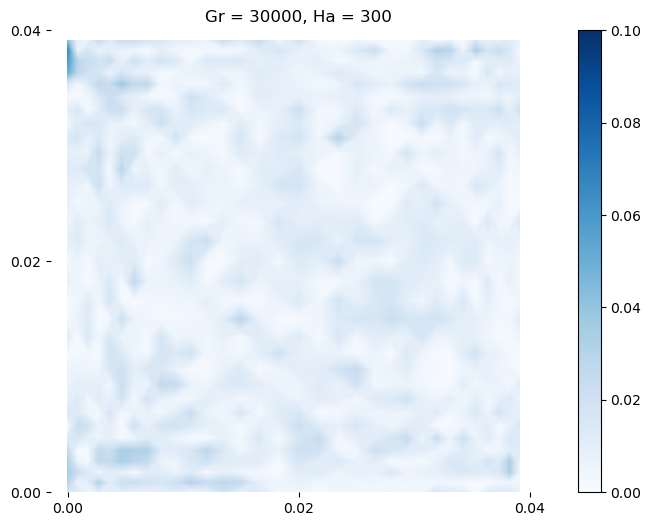

In [8]:
cut = 8
err = np.abs((w_cfd[12][:,:,cut] - (out_dict['w'].squeeze(1).squeeze(0)[:,:,cut]).numpy()) / w_cfd[12][:,:,cut].max())

# 自定义颜色条范围
vmin = 0
vmax = 0.1

# 创建一个假的图像对象来为colorbar提供颜色映射
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('Blues')

# 创建一个空的图像对象（没有显示数据）
fig, ax = plt.subplots(figsize=(8, 6))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')

c=plt.contourf(X[:,:,cut], Y[:,:,cut], err,cmap='Blues',levels=100, vmax=0.1)
plt.axis('equal')
plt.title('Gr = 30000, Ha = 300')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([0, 0.02, 0.04])
ax.set_yticks([0, 0.02, 0.04])
plt.savefig('result/Gr3e4,Ha3e2_err_nonuni.png')

In [ ]:
err.max()